In [1]:
# import gdown
# file_id = '17_boNLEhV6G0jwANXgjm6FClGLoMYmYI'
# output = 'blob'
# gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

In [2]:
# import zipfile
# zip_file_path = "blob"
# extract_to_directory = "extracted_files"
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_directory)
# print("Extraction complete.")

In [3]:
import time

def loading_time_calculator(dataloader):
    t1 = time.time()
    for data in dataloader:
        pass
    t2 = time.time()
    return t2 - t1

In [4]:
import csv
import numpy as np

class CustomDataset:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = self.load_dataset()

    def load_dataset(self):
        dataset = []
        with open(self.csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)
            for row in csv_reader:
                label = int(row[0])
                pixel_values = np.array([int(value) for value in row[1:]], dtype=np.uint8)
                image = pixel_values.reshape((28, 28))
                dataset.append((image, label))
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

csv_train_path = 'extracted_files/mnist_train.csv'
csv_test_path = 'extracted_files/mnist_test.csv'
custom_dataset = CustomDataset(csv_train_path)
test_data_custom = CustomDataset(csv_test_path)

In [5]:
# Splitting the train dataset into train and validation datasets

from sklearn.model_selection import train_test_split
train_data_custom, val_data_custom = train_test_split(custom_dataset, test_size=0.1, random_state=42)


In [6]:
print("Total length of training set in csv file:",len(custom_dataset))

print("Length of training set after splitting:",len(train_data_custom))
print("Length of validation set after splitting:",len(val_data_custom))
print("Total length of test set in csv file:",len(test_data_custom))

# Access a sample from the dataset
sample_image, sample_label = custom_dataset[0]
print(f"Label: {sample_label}, Image Shape: {sample_image.shape}")

Total length of training set in csv file: 60000
Length of training set after splitting: 54000
Length of validation set after splitting: 6000
Total length of test set in csv file: 10000
Label: 5, Image Shape: (28, 28)


Now we will construct the custom dataloader from scratch

In [7]:
class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        self.current_index = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.indices):
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_data = [self.dataset[i] for i in batch_indices]

        self.current_index += self.batch_size

        images, labels = zip(*batch_data)
        return np.array(images), np.array(labels)


In [8]:
batch_sizes = [128, 256, 512, 1024]

In [9]:
# Getting loading times for Scratch Implementation for all batch sizes

custom_time=[]
for i in batch_sizes:
    custom_dataloader = CustomDataLoader(custom_dataset, i)
    duration = loading_time_calculator(custom_dataloader)
    custom_time.append(duration)

Now we will do the Pytorch Implementation

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TorchDataset(Dataset):
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = self.load_dataset()

    def load_dataset(self):
        dataset = []
        with open(self.csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)
            for row in csv_reader:
                label = int(row[0])
                pixel_values = np.array([int(value) for value in row[1:]], dtype=np.uint8)
                image = pixel_values.reshape((28, 28))  # Assuming MNIST image dimensions are 28x28
                dataset.append((torch.tensor(image, dtype=torch.float32), label))
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        # Add channel dimension as torchvision expects (C, H, W)
        image = image.unsqueeze(0)
        return image, label

# Example usage
csv_file_path = 'extracted_files/mnist_train.csv'
torch_dataset = TorchDataset(csv_file_path)

transform = transforms.Compose([
    transforms.ToTensor()
])
input_data = np.random.randn(700, 28, 28)
label_data = np.random.randint(0, 10, size=(700,))

In [11]:
# Getting loading times for Pytorch Implementation for all batch sizes

torch_time = []
for i in batch_sizes:
    torch_dataloader = DataLoader(dataset=torch_dataset, batch_size=i, shuffle=True)
    duration = loading_time_calculator(torch_dataloader)
    print(duration)
    torch_time.append(duration)

0.3511185646057129
0.28040027618408203
0.29848313331604004
0.2852206230163574


In [12]:
print("Loading Times obtained for Pytorch Implementation: ",torch_time)
print("Loading Times obtained for Scratch Implementation: ",custom_time)

Loading Times obtained for Pytorch Implementation:  [0.3511185646057129, 0.28040027618408203, 0.29848313331604004, 0.2852206230163574]
Loading Times obtained for Scratch Implementation:  [0.07999515533447266, 0.08798980712890625, 0.08799886703491211, 0.10400605201721191]


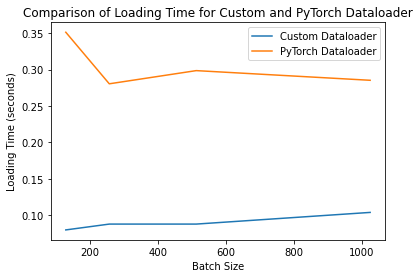

In [13]:
import matplotlib.pyplot as plt
plt.plot(batch_sizes, custom_time, label='Custom Dataloader')
plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.title('Comparison of Loading Time for Custom and PyTorch Dataloader')
plt.legend()
plt.show()

We can see from the above graphs that the Custom Dataloader takes less loading time than pytorch implementation. So for the next steps, we will choose the Custom dataset and dataloader having Batch Size- 512

Now we will Implement the Feed forward Neural Network using Pytorch

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedForward(nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = FeedForward()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003)
num_epochs = 60

In [15]:
epoch_list=list(range(1, 61))

train_loss_list=[]
validation_loss_list=[]
test_loss_list=[]

train_accuracy_list=[]
validation_accuracy_list=[]
test_accuracy_list=[]

Training the network and getting training, validation and test loss and accuracy

In [16]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    custom_dataloader = CustomDataLoader(train_data_custom, 512)
    for inputs, labels in custom_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    train_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Training Set: {accuracy}')
    train_accuracy_list.append(accuracy)
    print()


    # Getting validation loss and accuracy
    total_correct = 0
    total_samples = 0

    validation_dataloader = CustomDataLoader(val_data_custom, 512)
    for inputs, labels in validation_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {loss.item()}')
    validation_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Validation Set: {accuracy}')
    validation_accuracy_list.append(accuracy)
    print()

    # Getting test loss and accuracy
    total_correct = 0
    total_samples = 0

    test_dataloader = CustomDataLoader(test_data_custom, 512)
    for inputs, labels in test_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {loss.item()}')
    test_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Test Set: {accuracy}')
    test_accuracy_list.append(accuracy)
    

Epoch [1/60], Loss: 2.232560873031616
Epoch 0, Accuracy on Training Set: 0.12562962962962962

Epoch [1/60], Validation Loss: 2.2176804542541504
Epoch 0, Accuracy on Validation Set: 0.175

Epoch [1/60], Test Loss: 2.1833913326263428
Epoch 0, Accuracy on Test Set: 0.1855
Epoch [2/60], Loss: 1.9625672101974487
Epoch 1, Accuracy on Training Set: 0.2172962962962963

Epoch [2/60], Validation Loss: 1.9449012279510498
Epoch 1, Accuracy on Validation Set: 0.26166666666666666

Epoch [2/60], Test Loss: 2.0362961292266846
Epoch 1, Accuracy on Test Set: 0.27
Epoch [3/60], Loss: 1.7599260807037354
Epoch 2, Accuracy on Training Set: 0.3222777777777778

Epoch [3/60], Validation Loss: 1.7504771947860718
Epoch 2, Accuracy on Validation Set: 0.39066666666666666

Epoch [3/60], Test Loss: 1.8009473085403442
Epoch 2, Accuracy on Test Set: 0.3979
Epoch [4/60], Loss: 1.5254604816436768
Epoch 3, Accuracy on Training Set: 0.4662222222222222

Epoch [4/60], Validation Loss: 1.5131902694702148
Epoch 3, Accuracy on

Plotting the training vs validation vs test loss

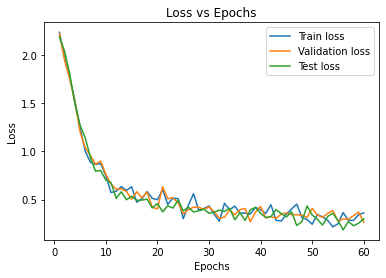

In [18]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.plot(epoch_list, validation_loss_list, label='Validation loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

Plotting the training vs validation vs test accuracy

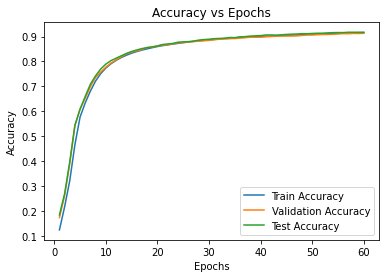

In [19]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, validation_accuracy_list, label='Validation Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

Now I will change the Activation function from Relu to Sigmoid

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedForwardSigmoid(nn.Module):
    def __init__(self):
        super(FeedForwardSigmoid, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)
        return x

model_sigmoid = FeedForwardSigmoid()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_sigmoid.parameters(), lr=0.0003)
num_epochs = 60

In [21]:
epoch_list=list(range(1, 61))

train_loss_list=[]
validation_loss_list=[]
test_loss_list=[]

train_accuracy_list=[]
validation_accuracy_list=[]
test_accuracy_list=[]

In [22]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    custom_dataloader = CustomDataLoader(train_data_custom, 512)
    for inputs, labels in custom_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        optimizer.zero_grad()
        outputs = model_sigmoid(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    train_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Training Set: {accuracy}')
    train_accuracy_list.append(accuracy)
    print()


    # Getting validation loss and accuracy
    total_correct = 0
    total_samples = 0

    validation_dataloader = CustomDataLoader(val_data_custom, 512)
    for inputs, labels in validation_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model_sigmoid(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {loss.item()}')
    validation_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Validation Set: {accuracy}')
    validation_accuracy_list.append(accuracy)
    print()

    # Getting test loss and accuracy
    total_correct = 0
    total_samples = 0

    test_dataloader = CustomDataLoader(test_data_custom, 512)
    for inputs, labels in test_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model_sigmoid(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {loss.item()}')
    test_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Test Set: {accuracy}')
    test_accuracy_list.append(accuracy)

Epoch [1/60], Loss: 2.3468399047851562
Epoch 0, Accuracy on Training Set: 0.10262962962962963

Epoch [1/60], Validation Loss: 2.3397247791290283
Epoch 0, Accuracy on Validation Set: 0.09816666666666667

Epoch [1/60], Test Loss: 2.3348536491394043
Epoch 0, Accuracy on Test Set: 0.101
Epoch [2/60], Loss: 2.326616048812866
Epoch 1, Accuracy on Training Set: 0.10262962962962963

Epoch [2/60], Validation Loss: 2.358175754547119
Epoch 1, Accuracy on Validation Set: 0.09816666666666667

Epoch [2/60], Test Loss: 2.325775146484375
Epoch 1, Accuracy on Test Set: 0.101
Epoch [3/60], Loss: 2.3582441806793213
Epoch 2, Accuracy on Training Set: 0.10262962962962963

Epoch [3/60], Validation Loss: 2.3400485515594482
Epoch 2, Accuracy on Validation Set: 0.09816666666666667

Epoch [3/60], Test Loss: 2.3191511631011963
Epoch 2, Accuracy on Test Set: 0.101
Epoch [4/60], Loss: 2.324620008468628
Epoch 3, Accuracy on Training Set: 0.10262962962962963

Epoch [4/60], Validation Loss: 2.326085090637207
Epoch 3,

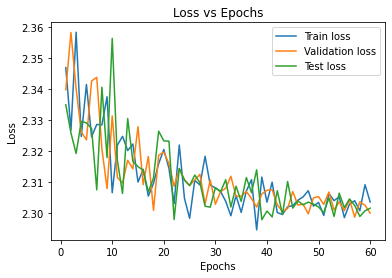

In [23]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.plot(epoch_list, validation_loss_list, label='Validation loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

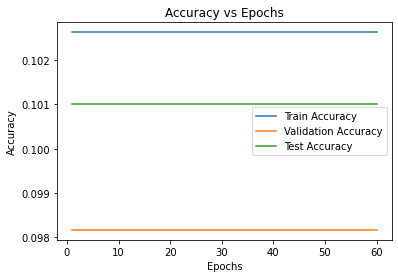

In [24]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, validation_accuracy_list, label='Validation Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

Now we will construct the Feed forward Neural Network from Scratch.

In [25]:
import numpy as np

class CustomFeedForwardNN:
    def __init__(self):
        self.weights = {
            'fc1': np.random.randn(28 * 28, 64),
            'fc2': np.random.randn(64, 64),
            'fc3': np.random.randn(64, 64),
            'fc4': np.random.randn(64, 64),
            'fc5': np.random.randn(64, 10)
        }

        self.biases = {
            'fc1': np.zeros((1, 64)),
            'fc2': np.zeros((1, 64)),
            'fc3': np.zeros((1, 64)),
            'fc4': np.zeros((1, 64)),
            'fc5': np.zeros((1, 10))
        }

        self.layer_outputs = {}

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        self.layer_outputs['fc0'] = x
        x = self.relu(np.dot(x, self.weights['fc1']) + self.biases['fc1'])
        self.layer_outputs['fc1'] = x
        x = self.relu(np.dot(x, self.weights['fc2']) + self.biases['fc2'])
        self.layer_outputs['fc2'] = x
        x = self.relu(np.dot(x, self.weights['fc3']) + self.biases['fc3'])
        self.layer_outputs['fc3'] = x
        x = self.relu(np.dot(x, self.weights['fc4']) + self.biases['fc4'])
        self.layer_outputs['fc4'] = x
        x = np.dot(x, self.weights['fc5']) + self.biases['fc5']
        self.layer_outputs['fc5'] = x
        return x

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true, epsilon=1e-15):
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, x, y_true, learning_rate):
        m = x.shape[0]

        # Calculate loss
        loss = self.cross_entropy_loss(self.softmax(self.layer_outputs['fc5']), y_true)

        # Backpropagation
        d_fc5 = self.softmax(self.layer_outputs['fc5'])
        d_fc5[range(m), y_true.argmax(axis=1)] -= 1
        d_fc5 /= m

        d_fc4 = np.dot(d_fc5, self.weights['fc5'].T)
        d_fc4[self.layer_outputs['fc4'] <= 0] = 0

        d_fc3 = np.dot(d_fc4, self.weights['fc4'].T)
        d_fc3[self.layer_outputs['fc3'] <= 0] = 0

        d_fc2 = np.dot(d_fc3, self.weights['fc3'].T)
        d_fc2[self.layer_outputs['fc2'] <= 0] = 0

        d_fc1 = np.dot(d_fc2, self.weights['fc2'].T)
        d_fc1[self.layer_outputs['fc1'] <= 0] = 0

        # Update weights and biases
        self.weights['fc5'] -= learning_rate * np.dot(self.layer_outputs['fc4'].T, d_fc5)
        self.biases['fc5'] -= learning_rate * np.sum(d_fc5, axis=0, keepdims=True)

        self.weights['fc4'] -= learning_rate * np.dot(self.layer_outputs['fc3'].T, d_fc4)
        self.biases['fc4'] -= learning_rate * np.sum(d_fc4, axis=0, keepdims=True)

        self.weights['fc3'] -= learning_rate * np.dot(self.layer_outputs['fc2'].T, d_fc3)
        self.biases['fc3'] -= learning_rate * np.sum(d_fc3, axis=0, keepdims=True)

        self.weights['fc2'] -= learning_rate * np.dot(self.layer_outputs['fc1'].T, d_fc2)
        self.biases['fc2'] -= learning_rate * np.sum(d_fc2, axis=0, keepdims=True)

        self.weights['fc1'] -= learning_rate * np.dot(self.layer_outputs['fc0'].T, d_fc1)
        self.biases['fc1'] -= learning_rate * np.sum(d_fc1, axis=0, keepdims=True)

        return loss

In [26]:
# custom_model = CustomFeedForwardNN()
# acc=0
# for epoch in range(60):
#     total_correct = 0
#     total_samples = 0
#     custom_dataloader = CustomDataLoader(train_data_custom, 512)
#     for inputs, labels in custom_dataloader:

#         outputs = custom_model.forward(inputs)
#         one_labels = np.eye(10)[labels]
#         loss = custom_model.backward(inputs, one_labels, 0.03)

#         acc = np.mean(np.argmax(custom_model.softmax(outputs), axis=1) == labels)
        
#         print("Accuracy:",acc)
    
#     print(f'Epoch [{epoch + 1}/60], Loss: {loss.item()}')


leooe
[[[-0.17879941 -1.2943474  -0.29518106 ...  0.83470347  0.58643979
   -0.30069371]
  [-0.95448529 -0.3154924   1.24942905 ...  0.81293384  0.7149898
    0.79688471]
  [-0.19053431  0.20121191 -0.9812074  ...  1.47713674 -0.84282938
    0.29768524]
  ...
  [ 0.82999672  1.13122368 -0.96439128 ... -0.69600211 -0.03300972
    0.42473678]
  [-0.29881029  1.34384613 -2.49777102 ... -0.7131615  -1.01584525
    0.33276953]
  [-0.60444627  0.03238205 -1.52558048 ... -0.72892834  0.95035432
   -0.51427177]]

 [[ 1.70991595 -0.1432191  -0.46074326 ... -0.27698381  0.18206365
   -0.60983776]
  [-0.33287396  1.7456564  -0.47883136 ...  0.83545956  1.68080101
   -0.86414428]
  [-1.68904556  0.65814482  0.01471067 ... -2.04654464  1.92631407
    2.119852  ]
  ...
  [ 0.69828682 -0.1659451  -2.02443827 ... -0.33367001 -0.31149171
   -1.02365371]
  [-1.06593335  1.20900625  0.71632219 ... -0.467472   -0.37247185
    0.29623348]
  [-1.12277528  0.48421942 -0.03348113 ... -1.11398321  0.26240766
 

In [58]:
train_accuracy_list = []
train_loss_list = []
one_hot_labels = np.eye(10)[label_data]

# Create the model
custom_model = CustomFeedForwardNN()

# Training loop
num_epochs = 60
learning_rate = 0.0003

for epoch in range(num_epochs):
    # Forward pass
    output = custom_model.forward(input_data)

    # Backward pass and optimization
    loss = custom_model.backward(input_data, one_hot_labels, learning_rate)
    acc = np.mean(np.argmax(custom_model.softmax(output), axis=1) == label_data)

    print("accuracy: ", acc)
    train_accuracy_list.append(acc)
    # Print loss for every 100 epochs

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss}')
    train_loss_list.append(loss)

# Test the trained model on new data
test_data = np.random.randn(10, 28, 28)
predictions = custom_model.forward(test_data)
print(predictions.argmax(axis=1))

accuracy:  0.09857142857142857
Epoch [0/60], Loss: 31.13423986455519
accuracy:  0.12
Epoch [1/60], Loss: 30.394123227521394
accuracy:  0.11428571428571428
Epoch [2/60], Loss: 30.59148766406374
accuracy:  0.11142857142857143
Epoch [3/60], Loss: 30.668465310130976
accuracy:  0.11571428571428571
Epoch [4/60], Loss: 30.542147982262758
accuracy:  0.1442857142857143
Epoch [5/60], Loss: 29.519942902456584
accuracy:  0.14857142857142858
Epoch [6/60], Loss: 29.341254136375678
accuracy:  0.1957142857142857
Epoch [7/60], Loss: 27.77904444333531
accuracy:  0.19
Epoch [8/60], Loss: 27.971937970056576
accuracy:  0.2342857142857143
Epoch [9/60], Loss: 26.42036701080328
accuracy:  0.21857142857142858
Epoch [10/60], Loss: 26.94153529707875
accuracy:  0.24285714285714285
Epoch [11/60], Loss: 26.06960881423527
accuracy:  0.2571428571428571
Epoch [12/60], Loss: 25.579755124189106
accuracy:  0.26857142857142857
Epoch [13/60], Loss: 25.178038362378274
accuracy:  0.2814285714285714
Epoch [14/60], Loss: 24.63

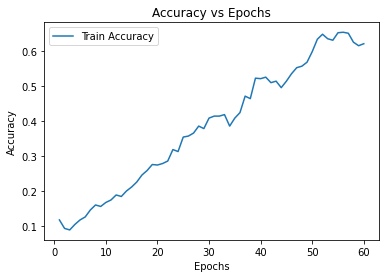

In [57]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

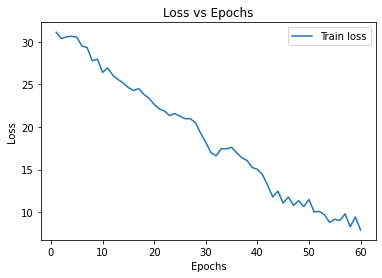

In [59]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

In [60]:
import numpy as np

class CustomFeedForwardNN_Sigmoid:
    def __init__(self):
        self.weights = {
            'fc1': np.random.randn(28 * 28, 64),
            'fc2': np.random.randn(64, 64),
            'fc3': np.random.randn(64, 64),
            'fc4': np.random.randn(64, 64),
            'fc5': np.random.randn(64, 10)
        }

        self.biases = {
            'fc1': np.zeros((1, 64)),
            'fc2': np.zeros((1, 64)),
            'fc3': np.zeros((1, 64)),
            'fc4': np.zeros((1, 64)),
            'fc5': np.zeros((1, 10))
        }

        self.layer_outputs = {}

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        self.layer_outputs['fc0'] = x
        x = self.sigmoid(np.dot(x, self.weights['fc1']) + self.biases['fc1'])
        self.layer_outputs['fc1'] = x
        x = self.sigmoid(np.dot(x, self.weights['fc2']) + self.biases['fc2'])
        self.layer_outputs['fc2'] = x
        x = self.sigmoid(np.dot(x, self.weights['fc3']) + self.biases['fc3'])
        self.layer_outputs['fc3'] = x
        x = self.sigmoid(np.dot(x, self.weights['fc4']) + self.biases['fc4'])
        self.layer_outputs['fc4'] = x
        x = np.dot(x, self.weights['fc5']) + self.biases['fc5']
        self.layer_outputs['fc5'] = x
        return x

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true, epsilon=1e-15):
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, x, y_true, learning_rate):
        m = x.shape[0]

        # Calculate loss
        loss = self.cross_entropy_loss(self.softmax(self.layer_outputs['fc5']), y_true)

        # Backpropagation
        d_fc5 = self.softmax(self.layer_outputs['fc5'])
        d_fc5[range(m), y_true.argmax(axis=1)] -= 1
        d_fc5 /= m

        d_fc4 = np.dot(d_fc5, self.weights['fc5'].T)
        d_fc4[self.layer_outputs['fc4'] <= 0] = 0

        d_fc3 = np.dot(d_fc4, self.weights['fc4'].T)
        d_fc3[self.layer_outputs['fc3'] <= 0] = 0

        d_fc2 = np.dot(d_fc3, self.weights['fc3'].T)
        d_fc2[self.layer_outputs['fc2'] <= 0] = 0

        d_fc1 = np.dot(d_fc2, self.weights['fc2'].T)
        d_fc1[self.layer_outputs['fc1'] <= 0] = 0

        # Update weights and biases
        self.weights['fc5'] -= learning_rate * np.dot(self.layer_outputs['fc4'].T, d_fc5)
        self.biases['fc5'] -= learning_rate * np.sum(d_fc5, axis=0, keepdims=True)

        self.weights['fc4'] -= learning_rate * np.dot(self.layer_outputs['fc3'].T, d_fc4)
        self.biases['fc4'] -= learning_rate * np.sum(d_fc4, axis=0, keepdims=True)

        self.weights['fc3'] -= learning_rate * np.dot(self.layer_outputs['fc2'].T, d_fc3)
        self.biases['fc3'] -= learning_rate * np.sum(d_fc3, axis=0, keepdims=True)

        self.weights['fc2'] -= learning_rate * np.dot(self.layer_outputs['fc1'].T, d_fc2)
        self.biases['fc2'] -= learning_rate * np.sum(d_fc2, axis=0, keepdims=True)

        self.weights['fc1'] -= learning_rate * np.dot(self.layer_outputs['fc0'].T, d_fc1)
        self.biases['fc1'] -= learning_rate * np.sum(d_fc1, axis=0, keepdims=True)

        return loss

In [61]:
train_accuracy_list = []
train_loss_list = []
one_hot_labels = np.eye(10)[label_data]

# Create the model
custom_model = CustomFeedForwardNN_Sigmoid()

# Training loop
num_epochs = 60
learning_rate = 0.0003

for epoch in range(num_epochs):
    # Forward pass
    output = custom_model.forward(input_data)

    # Backward pass and optimization
    loss = custom_model.backward(input_data, one_hot_labels, learning_rate)
    acc = np.mean(np.argmax(custom_model.softmax(output), axis=1) == label_data)

    print("accuracy: ", acc)
    train_accuracy_list.append(acc)
    # Print loss for every 100 epochs

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss}')
    train_loss_list.append(loss)

# Test the trained model on new data
test_data = np.random.randn(10, 28, 28)
predictions = custom_model.forward(test_data)
print(predictions.argmax(axis=1))

accuracy:  0.09428571428571429
Epoch [0/60], Loss: 5.447440853275726
accuracy:  0.09571428571428571
Epoch [1/60], Loss: 5.300474405822785
accuracy:  0.09428571428571429
Epoch [2/60], Loss: 5.160761981326049
accuracy:  0.09142857142857143
Epoch [3/60], Loss: 5.030464416866517
accuracy:  0.09571428571428571
Epoch [4/60], Loss: 4.910733369185066
accuracy:  0.09714285714285714
Epoch [5/60], Loss: 4.800890544787114
accuracy:  0.10142857142857142
Epoch [6/60], Loss: 4.69927189946438
accuracy:  0.10571428571428572
Epoch [7/60], Loss: 4.604216072397927
accuracy:  0.10285714285714286
Epoch [8/60], Loss: 4.5148574081065895
accuracy:  0.10285714285714286
Epoch [9/60], Loss: 4.431784683618443
accuracy:  0.09714285714285714
Epoch [10/60], Loss: 4.35599626348399
accuracy:  0.09571428571428571
Epoch [11/60], Loss: 4.287332294116286
accuracy:  0.09714285714285714
Epoch [12/60], Loss: 4.224205115863724
accuracy:  0.09714285714285714
Epoch [13/60], Loss: 4.164799043180741
accuracy:  0.1
Epoch [14/60], L

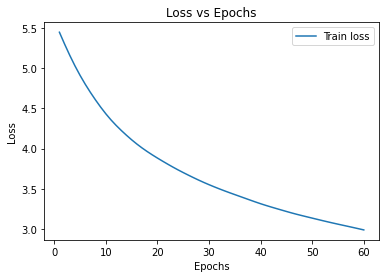

In [62]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

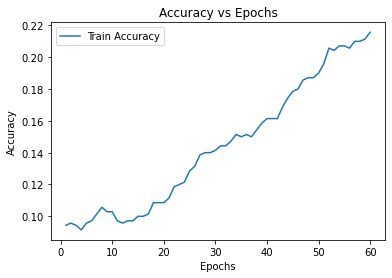

In [63]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()